
# **Running Hive on Pyspark in Colab**

Prepare PySpark Cluster

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

# Task 1 Prepare your google colab PySpark Session as you did before.

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
# spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()


# Task 2 Read 'BostonHousing.csv' dataset in PySpark. You may use other dataset as well if you want to.

In [3]:
# Step 1: Read the given CSV file
df = spark.read.csv('/content/BostonHousing.csv', sep=',', inferSchema=True, header=True)
df_main = df

In [4]:
df.show()

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

# Task 3 Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')

In [5]:
# Import required libraries
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Combine features to a single vector column using VectorAssembler
feature_columns = df.columns[:-1]  # All columns except the target column 'medv'
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_vector = assembler.transform(df)

# Task 4 Standardize features for principal component analysis

In [13]:
# Standardize features for principal component analysis
scaler = StandardScaler(
    inputCol='features',
    outputCol='scaledFeatures',
    withMean = True,
    withStd = True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)
df_scaled.show(10)

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|      scaledFeatures|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|[-0.4193669292132...|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|[-0.4169266699640...|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|[-0.4169289951277...|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|[-0.4163384035610...|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|[-0.41

# Task 5 Train model for two principal component analysis

In [21]:
# Train model for two principal component analysis
pca = PCA(k=2, inputCol='scaledFeatures', outputCol='pcaFeatures')
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# Print explained variance ratio
explained_variance_ratio = pca_model.explainedVariance.toArray()
print('Explained Variance Ratio:', explained_variance_ratio)
# df_pca.show(10)

Explained Variance Ratio: [0.47129606 0.11025193]


# Task 6 Collect distributed data in numpy array and then convert to pandas dataframe

In [23]:
# Collect distributed data in numpy array and then convert to pandas dataframe
import numpy as np
import pandas as pd

pca_features = np.array(df_pca.select('pcaFeatures').collect())
pca_features = np.array([x[0] for x in pca_features])  # Convert from Row object to numpy array

pca_features

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [24]:
pca_df = pd.DataFrame(pca_features, columns=['PC_first', 'PC_second'])
pca_df.head(10)

,PC_first,PC_second
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615
5,2.212662,-0.009478
6,1.357538,0.349526
7,0.841212,0.577228
8,0.179750,0.342180
9,1.073122,0.315889


# Task 7 Plot two principal components

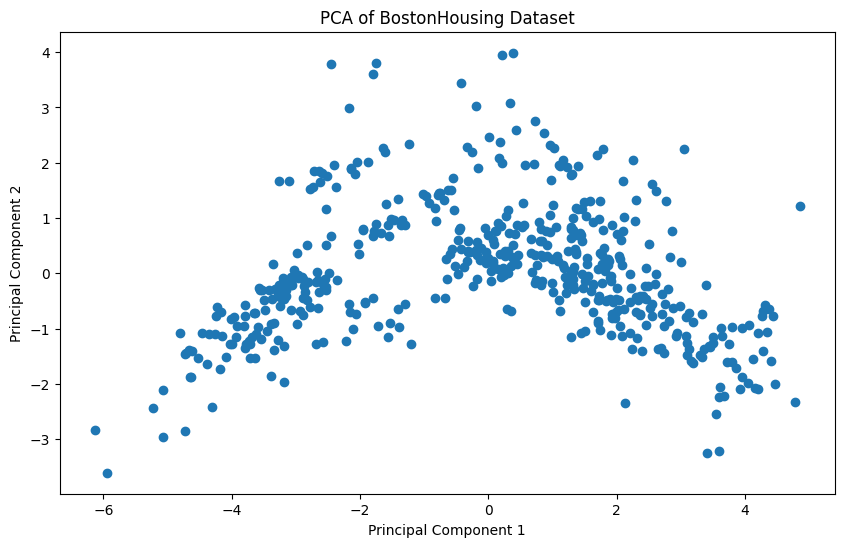

In [25]:
# Plot two principal components
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC_first'], pca_df['PC_second'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of BostonHousing Dataset')
plt.show()

# Task 8 Vectorize features and target together for model development

In [27]:
# Vectorize features and target together for model development
assembler_with_target = VectorAssembler(inputCols=feature_columns, outputCol='features_with_target')
assem_df = assembler_with_target.transform(df).select('features_with_target', 'medv')
assem_df.show()

+--------------------+----+
|features_with_target|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



# Task 9 Split dataset into training and testing dataset

In [28]:
# Split dataset into training and testing dataset
train_data, test_data = assem_df.randomSplit([0.8, 0.2])

# Task 10 Fit model for linear regression

In [30]:
# Fit model for linear regression
linear_reg = LinearRegression(featuresCol='features_with_target', labelCol='medv')
linear_reg = linear_reg.fit(train_data)

# Task 11 Find out model coefficients and intercept

In [31]:
#Find out model coefficients and intercept

# Get the coefficients and intercept
coeff = linear_reg.coefficients
intercept = linear_reg.intercept

print("Coefficients are:"+ str(coeff))
print("Intercept is: "+ str(intercept))

Coefficients are:[-0.09801137240693751,0.049843214425001996,0.00047468678723369055,2.6680122107234876,-13.214335518841855,3.6619672282008437,0.003069059330615798,-1.4795476280462487,0.2819274444827306,-0.01422655363430303,-0.8738665365614842,0.00821868870461839,-0.5648301869709501]
Intercept is: 35.26447245266744


# Task 12 Evaluate model for test dataset

In [32]:
#Evaluate model for test dataset

from pyspark.ml.evaluation import RegressionEvaluator

# Assuming you have a test dataset named 'test_data'
pred = linear_reg.evaluate(test_data)

# Predcit Model
pred.predictions.show(10)

+--------------------+----+------------------+
|features_with_target|medv|        prediction|
+--------------------+----+------------------+
|[0.01951,17.5,1.3...|33.0|23.392454271691413|
|[0.02177,82.5,2.0...|42.3| 36.79046891458719|
|[0.02498,0.0,1.89...|16.5|21.981229581554274|
|[0.02763,75.0,2.9...|30.8|31.652491476854742|
|[0.03237,0.0,2.18...|33.4|  28.9367884904011|
|[0.03578,20.0,3.3...|45.4| 38.67079626374885|
|[0.03659,25.0,4.8...|24.8|26.058837634155445|
|[0.03932,0.0,3.41...|22.0| 27.67794008266231|
|[0.04527,0.0,11.9...|20.6|23.136275810699143|
|[0.04741,0.0,11.9...|11.9| 23.17506677434472|
+--------------------+----+------------------+
only showing top 10 rows



# Task 13 Perform further analysis for better interpretation of model results.

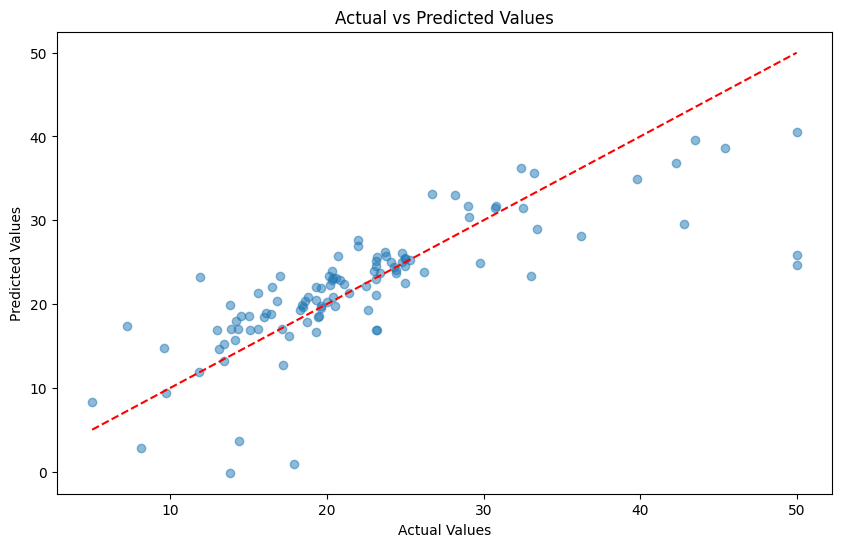

In [33]:
# Perform further analysis for better interpretation of model results
# Here you can analyze residuals, plot predicted vs actual values, etc.

# Example: Plotting predicted vs actual values
predictions = linear_reg.transform(test_data)
pred_df = predictions.select('medv', 'prediction').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(pred_df['medv'], pred_df['prediction'], alpha=0.5)
plt.plot([pred_df['medv'].min(), pred_df['medv'].max()], [pred_df['medv'].min(), pred_df['medv'].max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()